# Assembly Tree Generation and Evaluation

## Formulation
 - State Space S = {Every Possible Subassembly}
 - Action Space A = {Every Connection that can currently be removed}
 - P(s'|s,a) = Feasability Checks
 - R(s,a) = Cost of removing a certain + the 
 - Graph Assumption for modelling the 

## Notes
 - Next Steps:
     - Randomly generate rewards and show pathing possible
     - Rewards as a distance cost


In [1]:
import sys, random, math, time
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

## Preliminary Code (Object Classes)

In [2]:
class part:
    def __init__(self, number):
        self.num = number
        self.length = 1
        self.width = 1
        self.pos = []
        self.vel = []
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)
    def __str__(self):
        return "Part " + str(self.num)
    def __repr__(self):
        return "Part " + str(self.num)

# HELPER FUNCTIONS

In [14]:
def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, H, G):
    currCon = list(H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            Hnew = H.copy()
            Hnew.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in Hnew.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                idString = str(Hnew.edges())
                nextState = next((x for x, y in nx.get_node_attributes(G,'idS').items() if y == idString), None)
                if(nextState is not None):
                    G.add_node(i, value=Hnew, idS=idString)
                    G.add_edge(p,i, a=c, r=R(p,c))
                    G.add_edge(i,nextState, a=c, r=R(p,c))
                else:
                    G.add_node(i, value=Hnew, idS=idString)
                    G.add_edge(p,i, a=c, r=R(p,c))
                    G = recurGen(i, Hnew, G)
            i = G.number_of_nodes() + 1
        return G
    else:
        return G
    
    
# Checking Feasability
def P(sN, s, a):
    # Geometric Feasability
    pass
    # Sequential Constraints again


def genRewards(assembled):
    Rewards = {i: random.randint(0, 10) for i in list(assembled.H.edges())}
    return Rewards

def R(s, a):
    if((s,a) not in Rewards.keys()):
        Rewards[(s,a)] = random.randint(0, 10)
    return Rewards[(s,a)]

## Scenario Initialization

In [4]:
# Initialize the inputs (will later read in from file [JSON])
numAgents = 1
numParts = 15
#numConnections = int(numParts*(numParts-1)/2)
#numActions = int(sum([float(math.factorial(numConnections))/float(math.factorial(i)) for i in range(0, numConnections)]))
#numStates = numActions+1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {}
# seqConstraint = {(0, 2): (0, 1),
#                  (1, 3): (2, 3),
#                  (1, 2): (1, 3),
#                  (0, 1): (0, 2)}

# print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
#      % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

## Running the Assembly Generation

In [15]:
# Simple initial initialization (will later read in from file [JSON])
Rewards = {}

H = nx.Graph()
for i in range(numParts):
    n = part(i)
    H.add_node(i, value=n)
    if(i > 0):
        H.add_edge(i-1, i)
    #H.add_edges_from([(i,j) for j in range(numParts) if i != j])

# Generate the assembly tree
start = time.time()
G = nx.DiGraph()
G.add_node(1, value=H, idS=str(H.edges()))
G = recurGen(1, H, G)
end = time.time()
print("Assembly Generation Time: %f" % (end-start))


print(list(H.edges()))
print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

Assembly Generation Time: 3965.561782
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]
DONE: 114689 Nodes and 212993 Edges


## Value Iteration

In [16]:
def ValueIteration(G, H, maxIter, eps):
    S = range(1, G.number_of_nodes()+1)
    A = list(H.edges())

    V = {s: 0.0 for s in S}
    Vnew = V.copy()
    π = {s: (0, (0,0)) for s in S}
    delta = max([abs(V[s] - Vnew[s]) for s in S])

    c = 0
    while(c <= maxIter):
        delta = 0
        for s in S:
            nextStates = G[s]
            for sN in nextStates.items():
                newV = sN[1]['r'] + V[sN[0]]
                if(newV > Vnew[s]):
                    Vnew[s] = newV
                    π[s] = (sN[0], sN[1]['a'])
        delta = max([abs(V[s] - Vnew[s]) for s in S])
        if(delta < eps):
            print("Converged!")
            return Vnew, π
        V = Vnew.copy()
        c += 1
    print("Done")

maxIter = 100000
eps = 1e-6
start = time.time()
V, π = ValueIteration(G, H, maxIter, eps)
end = time.time()
print("Value Iteration Time: %f" % (end-start))

Converged!
Value Iteration Time: 4.557435


# Graphing Suite

In [17]:
try:
    pos = hierarchy_pos(G,1)
except:
    pos = nx.planar_layout(G)
actions = nx.get_edge_attributes(G,'r')
labels = nx.get_node_attributes(G,'r')
nx.draw(G, pos, with_labels=True, font_color="#FFFFFF")
nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)


try:
    S = range(1, G.number_of_nodes()+1)
    path = [1, π[1][0]]
    path_edges = [(1, path[-1])]
    while(True):
        currState = path[-1]
        nextState = π[currState][0]
        if(nextState in S):
            path.append(nextState)
            path_edges.append((currState, nextState))
        else:
            break
    print(path_edges)
    nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='r')
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='r',width=1)
except:
    print("No Policy Found")

print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

NetworkXException: G is not planar.

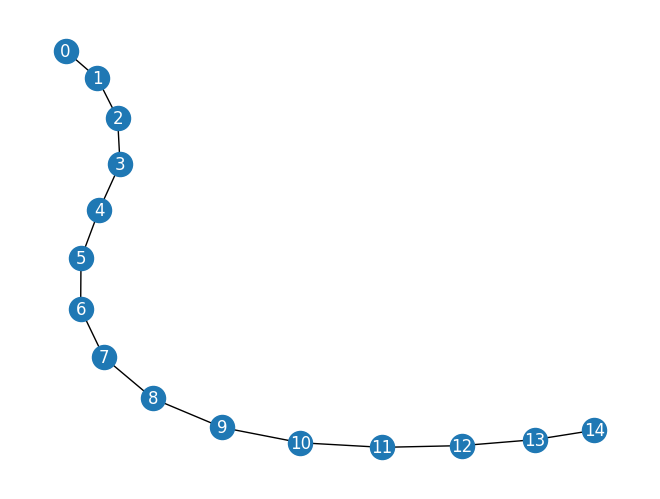

In [18]:
nx.draw(H, with_labels=True, font_color="#FFFFFF")